In [1]:
!ls
!pwd

README.md                 SVM-test.csv              test MFCC.ipynb
SVD                       Untitled Folder           test.csv
SVD Plots.ipynb           archived                  testSVD
SVD_data1.csv             data                      testSVD Plots.ipynb
SVDwithMFCC.csv           praat.Collection          testSVD_data1.csv
SVM test with J,S,H.ipynb scripts
/Users/leochoo/dev/GP2-dev


In [2]:
# initialize
import glob
import parselmouth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# filepath for the dataset
# root = "/Users/leochoo/dev/GP2-dev/SVD"
root = "./testSVD"

my_data_path = root + "/my_data"
healthy_path = root + "/healthy"
patho_path = root + "/pathological"

!ls {patho_path}
print(my_data_path)
# on MacOS, it creates a hidden .DS_Store folder that only be shown using `ls -la` command. You should delete it to ge the code working! :)

/Users/leochoo/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


functional      hyperfunctional organic         psychogenic
./testSVD/my_data


In [3]:
from tqdm import tqdm
from time import sleep

def get_voice_data(_path):
    # select .wav files only
    wav_files = glob.glob(_path + "/*.wav")

    n_list = []
    tone_list = []
    syllab_list = []

    j_list = []
    s_list = []
    h_list = []

    # for wav_file in wav_files:
    for wav_file in tqdm(wav_files): # tqdm shows the progress bar
        sound = parselmouth.Sound(wav_file) # sound object from wav file
        pitch = sound.to_pitch()
        pulses = parselmouth.praat.call([sound, pitch], "To PointProcess (cc)")

        # name analysis
        name = os.path.basename(wav_file).split(".")[0]  
        
        ## tone
        if "l" in name:
            tone_list.append("l")
        elif "n" in name:
            tone_list.append("n")
        elif "h" in name:
            tone_list.append("h")

        ## syllable
        if "a" in name:
            syllab_list.append("a")
        elif "i" in name:
            syllab_list.append("i")
        elif "u" in name:
            syllab_list.append("u")
        # jitter
        jitter_local = parselmouth.praat.call(pulses, "Get jitter (local)", 0.0, 0.0, 0.0001, 0.02, 1.3) * 100

        # shimmer
        shimmer_local = parselmouth.praat.call([sound, pulses], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

        # HNR
        harmonicity = parselmouth.praat.call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
        hnr = parselmouth.praat.call(harmonicity, "Get mean", 0, 0)

        # Append to dataframe
        n_list.append(name)
        j_list.append(jitter_local)
        s_list.append(shimmer_local)
        h_list.append(hnr)


    # create dataframe
    df = pd.DataFrame({"Name":pd.Series(n_list),
                        "Type": np.nan,
                        "Tone": pd.Series(tone_list),
                        "Syllab": pd.Series(syllab_list),
                           "Jitter":pd.Series(j_list),
                           "Shimmer":pd.Series(s_list),
                           "HNR":pd.Series(h_list)})
    df["Type"]= _path.split("/")[-1] # identify type: my_data, healthy, functional etc...
    df = df.dropna()
    return df


In [4]:
# get data and show dataframe
my_data_df = get_voice_data(my_data_path)
my_data_df.head()

100%|██████████| 9/9 [00:02<00:00,  4.43it/s]


,Name,Type,Tone,Syllab,Jitter,Shimmer,HNR
0,myd_a_h,my_data,h,a,0.222252,0.017838,28.288537
1,myd_a_l,my_data,l,a,0.487569,0.023036,21.677873
2,myd_a_n,my_data,n,a,0.222252,0.017838,28.288537
3,myd_u_n,my_data,n,u,0.164563,0.011110,30.354595
4,myd_u_l,my_data,l,u,0.279021,0.013981,28.079217


In [5]:

healthy_df = get_voice_data(healthy_path)
healthy_df.head()

functional_df = get_voice_data(patho_path + "/functional")
functional_df.head()

hyperfunctional_df = get_voice_data(patho_path + "/hyperfunctional")
hyperfunctional_df.head()

organic_df = get_voice_data(patho_path + "/organic")
organic_df.head()

psychogenic_df = get_voice_data(patho_path + "/psychogenic")

100%|██████████| 27/27 [00:01<00:00, 14.18it/s]


In [6]:
# Combine to one dataframe
frames = [my_data_df, healthy_df, functional_df, hyperfunctional_df, organic_df, psychogenic_df]
total_df = pd.concat(frames, keys=["my_data", "healthy_df", "functional", "hyperfunctional", "organic", "psychogenic"])

total_df.to_csv ("./testSVD_data1.csv", index = False, header=True)
print(total_df)

                   Name         Type Tone Syllab    Jitter   Shimmer  \
my_data     0   myd_a_h      my_data    h      a  0.222252  0.017838   
            1   myd_a_l      my_data    l      a  0.487569  0.023036   
            2   myd_a_n      my_data    n      a  0.222252  0.017838   
            3   myd_u_n      my_data    n      u  0.164563  0.011110   
            4   myd_u_l      my_data    l      u  0.279021  0.013981   
...                 ...          ...  ...    ...       ...       ...   
psychogenic 22  151-a_l  psychogenic    l      a  0.100698  0.010602   
            23  366-u_n  psychogenic    n      u  0.201356  0.015767   
            24  741-a_h  psychogenic    h      a  0.281613  0.026882   
            25  366-u_l  psychogenic    l      u  0.389981  0.039966   
            26  151-a_n  psychogenic    n      a  0.448863  0.024517   

                      HNR  
my_data     0   28.288537  
            1   21.677873  
            2   28.288537  
            3   30.3545

In [7]:
new_df = pd.concat(frames)
new_df

,Name,Type,Tone,Syllab,Jitter,Shimmer,HNR
0,myd_a_h,my_data,h,a,0.222252,0.017838,28.288537
1,myd_a_l,my_data,l,a,0.487569,0.023036,21.677873
2,myd_a_n,my_data,n,a,0.222252,0.017838,28.288537
3,myd_u_n,my_data,n,u,0.164563,0.011110,30.354595
4,myd_u_l,my_data,l,u,0.279021,0.013981,28.079217
...,...,...,...,...,...,...,...
22,151-a_l,psychogenic,l,a,0.100698,0.010602,32.236174
23,366-u_n,psychogenic,n,u,0.201356,0.015767,31.531414
24,741-a_h,psychogenic,h,a,0.281613,0.026882,28.802297
25,366-u_l,psychogenic,l,u,0.389981,0.039966,23.895287


In [8]:
new_df.loc[(new_df["Type"] == "healthy") & (new_df["Tone"] == "l") & (new_df["Syllab"] == "a")]

,Name,Type,Tone,Syllab,Jitter,Shimmer,HNR
13,2-a_l,healthy,l,a,0.500103,0.024036,25.397455
15,1-a_l,healthy,l,a,0.191396,0.010283,29.784809


In [9]:
# file number count
# all gender

# functional
#     1008

# hyperfunctional
#     1916

# organic
#      909
     
# psychogenic
#      819
file_numbers = [1008, 1916, 909, 819]
print(file_numbers)
print("# of people per type", [x//9 for x in file_numbers]) #f, h, o, p

[1008, 1916, 909, 819]
# of people per type [112, 212, 101, 91]


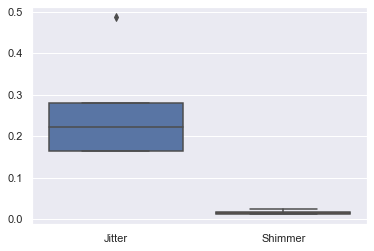

In [10]:
sns.set()
sns.boxplot(data = my_data_df.drop(["HNR"], axis=1))


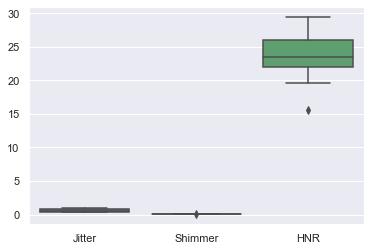

In [11]:
sns.boxplot(data = organic_df)
plt.show()

In [12]:
frames = [my_data_df, organic_df]

result = pd.concat(frames, keys=["my_data","organic"])
result.head()

Name     Type Tone Syllab    Jitter   Shimmer        HNR
my_data 0  myd_a_h  my_data    h      a  0.222252  0.017838  28.288537
        1  myd_a_l  my_data    l      a  0.487569  0.023036  21.677873
        2  myd_a_n  my_data    n      a  0.222252  0.017838  28.288537
        3  myd_u_n  my_data    n      u  0.164563  0.011110  30.354595
        4  myd_u_l  my_data    l      u  0.279021  0.013981  28.079217

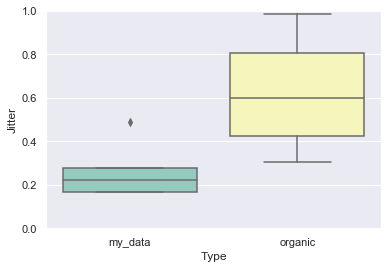

In [13]:
plt.ylim(0, 1)
sns.boxplot(x="Type", y="Jitter", data=result, palette="Set3")


In [14]:
organic_df.loc[organic_df.Tone == "l"]

,Name,Type,Tone,Syllab,Jitter,Shimmer,HNR
0,445-i_l,organic,l,i,0.540254,0.018591,24.334806
1,368-i_l,organic,l,i,0.860867,0.036633,23.453634
10,445-u_l,organic,l,u,0.690482,0.031553,25.089014
11,368-u_l,organic,l,u,0.902104,0.070926,19.781639
12,368-a_l,organic,l,a,0.964770,0.036703,22.765588
13,445-a_l,organic,l,a,0.653534,0.046101,19.602004


In [15]:
organic_df.loc[(organic_df.Tone == "l") & (organic_df.Syllab == "i")]

,Name,Type,Tone,Syllab,Jitter,Shimmer,HNR
0,445-i_l,organic,l,i,0.540254,0.018591,24.334806
1,368-i_l,organic,l,i,0.860867,0.036633,23.453634


In [16]:
def select_from_data(_df, _tone, _syllab, _param):
    result = _df.loc[(_df.Tone == _tone) & (_df.Syllab == _syllab)][_param]
    return result

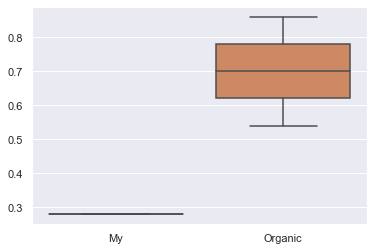

In [17]:
my_jitter = select_from_data(my_data_df, "l", "i", "Jitter")
organic_jitter = select_from_data(organic_df, "l", "i", "Jitter")
my_organic_j = pd.DataFrame({"My":pd.Series(my_jitter), "Organic":pd.Series(organic_jitter)})
sns.boxplot(data = my_organic_j)

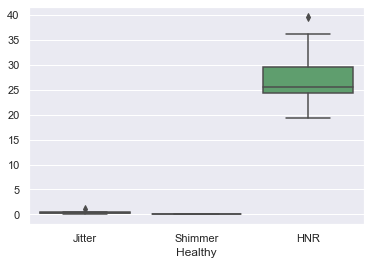

In [18]:
plt.xlabel("Healthy")
sns.boxplot(data = healthy_df)

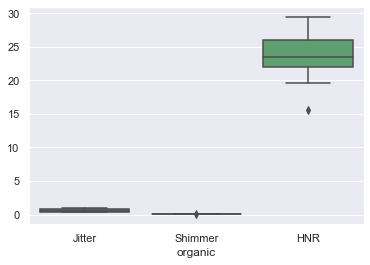

In [19]:
plt.xlabel("organic")
sns.boxplot(data = organic_df)

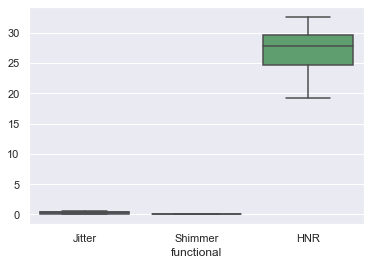

In [20]:
plt.xlabel("functional")
sns.boxplot(data = functional_df)

In [21]:
functional_df

,Name,Type,Tone,Syllab,Jitter,Shimmer,HNR
0,350-a_n,functional,n,a,0.149364,0.024658,28.264699
1,351-a_h,functional,h,a,0.622685,0.037482,22.785389
2,350-a_l,functional,l,a,0.131557,0.016773,29.744053
3,350-a_h,functional,h,a,0.178579,0.017611,27.779174
4,351-a_l,functional,l,a,0.479336,0.041689,22.565679
5,351-a_n,functional,n,a,0.503399,0.050224,21.277874
6,350-i_n,functional,n,i,0.128683,0.016487,30.198271
7,351-i_h,functional,h,i,0.477179,0.026774,24.843892
8,350-i_l,functional,l,i,0.112764,0.010442,32.643555
9,350-i_h,functional,h,i,0.145484,0.011612,31.839918


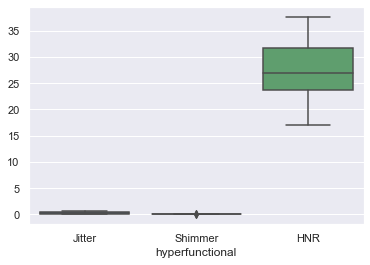

In [22]:
plt.xlabel("hyperfunctional")
sns.boxplot(data = hyperfunctional_df)

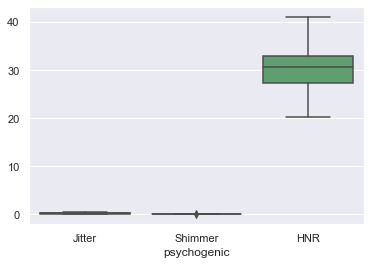

In [23]:
plt.xlabel("psychogenic")
sns.boxplot(data = psychogenic_df)

In [24]:
# dict of dataframes
dict_df = {"my_data": my_data_df,
"healthy": healthy_df,
"functional": functional_df,
"hyperfunctional": hyperfunctional_df,
"organic": organic_df,
"psychogenic": psychogenic_df,
}

In [25]:
for k,v in dict_df.items():
    print(k)


my_data
healthy
functional
hyperfunctional
organic
psychogenic


In [26]:
# selecting for tone and syllab
def select_tone_syllab(_tone, _syllab, _param):
    global dict_df
    result_df = pd.DataFrame()
    for type, _df in dict_df.items():
        selected_column = _df.loc[(_df.Tone == _tone) & (_df.Syllab == _syllab)][_param].values
        additional = pd.DataFrame({type: selected_column})
        result_df = pd.concat([result_df, additional], axis=1)
    return result_df

In [27]:
filtered_df = select_tone_syllab("l", "a", "Jitter")
filtered_df.head()

,my_data,healthy,functional,hyperfunctional,organic,psychogenic
0,0.487569,0.500103,0.131557,0.411039,0.964770,0.508194
1,NaN,0.191396,0.479336,0.653374,0.653534,0.254183
2,NaN,NaN,NaN,NaN,NaN,0.100698


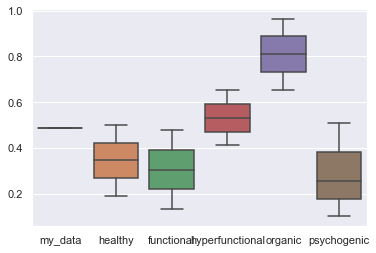

In [28]:
sns.boxplot(data=filtered_df)

In [29]:
# selecting just for tone
def select_one_tone(_tone, _param):
    global dict_df
    result_df = pd.DataFrame()
    for type, _df in dict_df.items():
        selected_column = _df.loc[(_df.Tone == _tone)][_param].values
        additional = pd.DataFrame({type: selected_column})
        result_df = pd.concat([result_df, additional], axis=1)
    return result_df

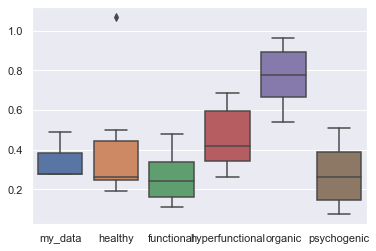

In [30]:
# box plot for all jitter in low tone
all_jitter_l = select_one_tone("l","Jitter")
sns.boxplot(data = all_jitter_l)

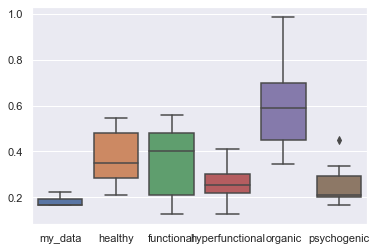

In [31]:
# box plot for all jitter in low tone
all_jitter_n = select_one_tone("n","Jitter")
sns.boxplot(data = all_jitter_n)

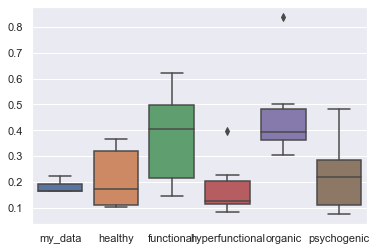

In [32]:
# box plot for all jitter in low tone
all_jitter_h = select_one_tone("h","Jitter")
sns.boxplot(data = all_jitter_h)

In [33]:
# 
frames = [my_data_df, organic_df, functional_df]

myd_org = pd.concat(frames, keys=["my_data","organic", "functional"])
myd_org.loc[myd_org.Syllab == "a"]


Name        Type Tone Syllab    Jitter   Shimmer        HNR
my_data    0   myd_a_h     my_data    h      a  0.222252  0.017838  28.288537
           1   myd_a_l     my_data    l      a  0.487569  0.023036  21.677873
           2   myd_a_n     my_data    n      a  0.222252  0.017838  28.288537
organic    12  368-a_l     organic    l      a  0.964770  0.036703  22.765588
           13  445-a_l     organic    l      a  0.653534  0.046101  19.602004
           14  445-a_n     organic    n      a  0.987353  0.080456  15.625524
           15  368-a_n     organic    n      a  0.435160  0.042159  20.478885
           16  368-a_h     organic    h      a  0.839461  0.049347  23.597963
           17  445-a_h     organic    h      a  0.419651  0.034329  22.937231
functional 0   350-a_n  functional    n      a  0.149364  0.024658  28.264699
           1   351-a_h  functional    h      a  0.622685  0.037482  22.785389
           2   350-a_l  functional    l      a  0.131557  0.016773  29.744053
           3   350-a_h  functional    h      a  0.178579  0.017611  27.779174
           4   351-a_l  functional    l      a  0.479336  0.041689  22.565679
           5   351-a_n  functional    n      a  0.503399  0.050224  21.277874

# can graph Jitter, Shimmer, HNR for all other dicts
dd = pd.melt(myd_org, id_vars=["Type"], value_vars=["Jitter", "Shimmer"])
dd.head

In [34]:
sns.boxplot(x="Type", y="value", data=dd, hue="variable")

NameError: name 'dd' is not defined